In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold, LeaveOneGroupOut, StratifiedKFold
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import statsmodels.formula.api as smf
from tqdm import tqdm
import itertools
from sklearn.preprocessing import StandardScaler

In [2]:
inDIR = '../data/training/'
inFILE = 'vor_2013_2022_cln_2023_04_26_hls_idxs.csv'

inPATH = os.path.join(inDIR, inFILE)

outDIR = './results/'

var_names = ['dfi', 'ndvi', 'ndti', 'satvi', 'ndii7', 
             'blue', 'green', 'red', 'nir', 'swir1', 'swir2',
             'bai_126', 'bai_136', 'bai_146', 'bai_236', 'bai_246', 'bai_346']

var_dict = {
    'NDVI': 'ndvi',
    'DFI': 'dfi',
    'NDTI': 'ndti',
    'SATVI': 'satvi',
    'NDII7': 'ndii7',
    'BAI_126': 'bai_126',
    'BAI_136': 'bai_136',
    'BAI_146': 'bai_146',
    'BAI_236': 'bai_236',
    'BAI_246': 'bai_246',
    'BAI_346': 'bai_346',
    'BLUE': 'blue',
    'GREEN': 'green',
    'RED': 'red',
    'NIR1': 'nir',
    'SWIR1': 'swir1',
    'SWIR2': 'swir2'
}

xv_vars = ['dfi', 'ndti', 'satvi', 'ndii7', 'swir1', 'swir2']
nsplits = 10

rand_st = 2313

In [3]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [4]:
df_results = pd.read_csv(os.path.join(outDIR, "VOR_lreg_results.csv"))
df_results_full = pd.read_csv(os.path.join(outDIR, "VOR_lreg_results_full.csv"))

In [5]:
df_vor = pd.read_csv(inPATH, parse_dates=[2, 3])
df_vor = df_vor.rename(columns=var_dict)

In [6]:
df_vor = df_vor[df_vor['Season'].isin(['June', 'October'])].copy()
df_vor = df_vor[df_vor['Year'] >= 2017].copy()

In [7]:
# check for any missing data
len(df_vor[df_vor[var_names].isnull().any(axis=1)])

0

In [8]:
# remove missing data
df_vor = df_vor[~df_vor[var_names].isnull().any(axis=1)].copy()
#df_vor = df_vor[~df_vor['Id'].isin(df_vor[df_vor[var_names].isnull().any(axis=1)]['Id'].unique())].copy()

In [9]:
X_vars_all = df_vor[var_names]
Y_var_all = df_vor['Biomass_kg_ha']

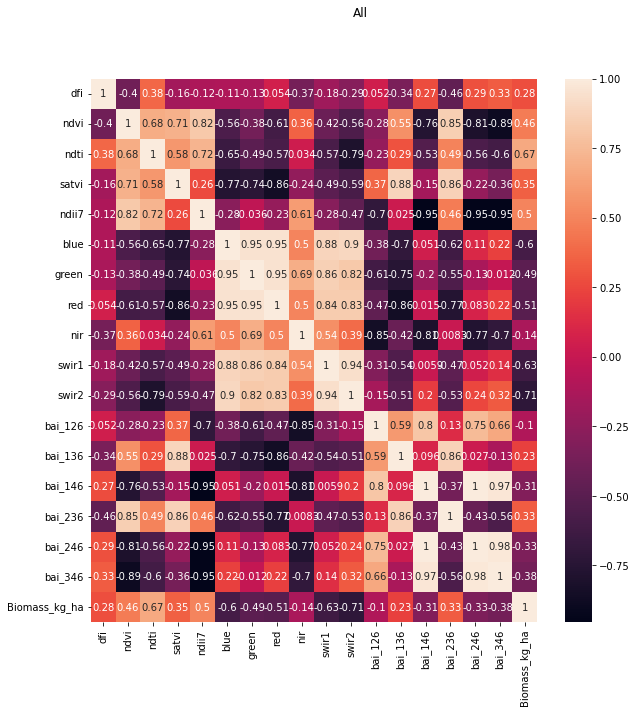

In [10]:
corrMatrix = X_vars_all.reset_index(drop=True).join(Y_var_all.reset_index(drop=True)).corr()
plt.figure(figsize=(10, 10))
plt.suptitle('All')
sns.heatmap(corrMatrix, annot=True)
plt.show()

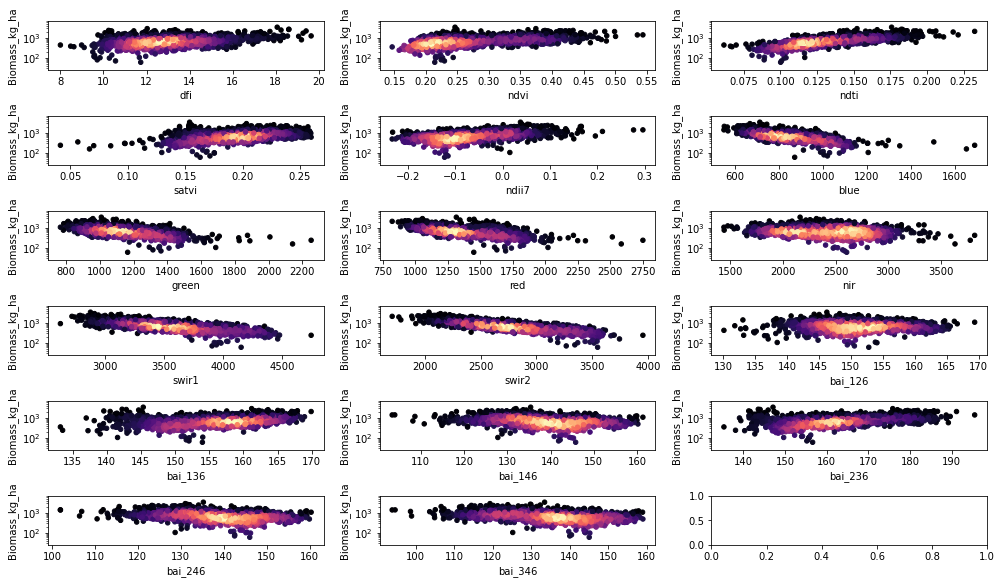

In [11]:
fig, axs = plt.subplots(figsize=(14, 8),
                        nrows=int(np.ceil(len(var_names) / 3)), ncols=3)
for idx, v in enumerate(var_names):
    xy_bm = np.vstack([df_vor[v], df_vor['Biomass_kg_ha']])
    z_bm = gaussian_kde(xy_bm)(xy_bm)
    df_vor.plot.scatter(x=v, y='Biomass_kg_ha', logy=True, ax=axs.flatten()[idx], ylim=(25, 7000),
                            c=z_bm, cmap='magma', colorbar=False)
    plt.tight_layout(pad=1.0)

In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_decomposition import PLSRegression

In [18]:
lr_form = df_results['formula'][413]

df_vor['bm_pred_rf_yr'] = np.nan
df_vor['bm_pred_rft_yr'] = np.nan
df_vor['bm_pred_lr_yr'] = np.nan
df_vor['bm_pred_mlp_yr'] = np.nan
df_vor['bm_pred_pls_yr'] = np.nan

var_names_simp = list(X_vars_all.columns)

scaler = StandardScaler()
mod_logo = LeaveOneGroupOut()
mod_skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rand_st)
scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error', 'MAPE': 'neg_mean_absolute_percentage_error'}
param_grid = {
    'bootstrap': [True],
    'max_depth': [None],
    'max_features': [2, 4, 6, len(var_names_simp)],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 5],
    'n_estimators': [500, 1000]
}

simp = True
log_xfrm = True
wtd = False
smap_xv = False
tune_rf = True
scale_vars = True
fit_mlp = True
fit_pls = True
mae_all_full_ktests = []
mae_all_full_lr_ktests = []
mae_tuned_ktests = []
mae_mlp_ktests = []
mae_pls_ktests = []
for train_index, test_index in mod_logo.split(X_vars_all, groups=df_vor['Date'].dt.year, ):
    print("Running K-fold = " + str(df_vor['Date'].dt.year.iloc[test_index].unique()))
    rf_all_tmp = RandomForestRegressor(n_estimators=500, random_state=rand_st)
    if wtd:
        lreg_tmp = smf.wls(formula=lr_form,
                           data=df_vor.iloc[train_index], weights=1 / df_vor.Biomass_kg_ha.iloc[train_index]).fit()
    else:
        lreg_tmp = smf.ols(formula=lr_form,
                           data=df_vor.iloc[train_index]).fit()
    if log_xfrm:
        see_tmp = np.sqrt(np.sum((np.log(df_vor['Biomass_kg_ha'].iloc[train_index]) -
                                  lreg_tmp.predict(df_vor.iloc[train_index])) ** 2) /
                          (len(train_index) - len(lreg_tmp.params)))
        cf_tmp = np.exp(see_tmp ** 2 / 2)  # correction factor from Sprugel 1983
        predictions_all_lr_tmp = np.exp(lreg_tmp.predict(df_vor.iloc[test_index]))  # * cf_tmp
    else:
        predictions_all_lr_tmp = lreg_tmp.predict(df_vor.iloc[test_index])
    if simp:
        all_X = df_vor[var_names_simp].iloc[test_index, :]
        all_x = df_vor[var_names_simp].iloc[train_index, :]
        scaler.fit(all_x)
    else:
        all_X = df_vor[var_names + xv_names].iloc[test_index, :]
        all_x = df_vor[var_names + xv_names].iloc[train_index, :]
        scaler.fit(all_x)
    if scale_vars:
        all_x = scaler.transform(all_x)
        all_X = scaler.transform(all_X)
    all_y = Y_var_all.iloc[train_index]
    rf_all_tmp.fit(all_x, all_y)

    all_Y = Y_var_all.iloc[test_index]
    predictions_all_tmp = rf_all_tmp.predict(all_X)
    mae_all_full_ktests.append(round(np.mean(np.abs(predictions_all_tmp - all_Y)), 2))
    mae_all_full_lr_ktests.append(round(np.mean(np.abs(predictions_all_lr_tmp - all_Y)), 2))
    
    df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
    df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
    
    if tune_rf:
        #rf_cv_all = mod_skf.split(all_x, df_vor['Year'].iloc[train_index])
        rf_cv_all = mod_logo.split(all_x, groups=df_vor['Date'].dt.year.iloc[train_index])

        # Create a base model
        rf_all_m1 = RandomForestRegressor(random_state=rand_st)
        # Instantiate the grid search model
        grid_search_all_m1 = GridSearchCV(estimator=rf_all_m1,
                                          param_grid=param_grid,
                                          scoring=scoring, 
                                          refit='MAPE', 
                                          return_train_score=True,
                                          cv=rf_cv_all, 
                                          n_jobs=-1, 
                                          verbose=0)
        grid_search_all_m1.fit(all_x, all_y)
        params_all_m1 = grid_search_all_m1.best_params_
        rf_all_m2 = RandomForestRegressor(n_estimators=params_all_m1['n_estimators'],
                                          min_samples_split=params_all_m1['min_samples_split'],
                                          min_samples_leaf=params_all_m1['min_samples_leaf'],
                                          max_features=params_all_m1['max_features'],
                                          bootstrap=params_all_m1['bootstrap'],
                                          max_depth=params_all_m1['max_depth'],
                                          random_state=rand_st)
        rf_all_m2.fit(all_x, all_y)
        # Use the forest's predict method on the test data
        predictions_all_tmp_m2 = rf_all_m2.predict(all_X)
        mae_tuned_ktests.append(round(np.mean(np.abs(predictions_all_tmp_m2 - all_Y)), 2))
        df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_all_tmp_m2
    if fit_mlp:
        mlp_all = GradientBoostingRegressor(loss='absolute_error',
                                            n_estimators=500,
                                            random_state=rand_st,
                                            max_depth=3)
        mlp_all.fit(all_x, all_y)
        predictions_all_tmp_mlp = mlp_all.predict(all_X)
        mae_mlp_ktests.append(round(np.mean(np.abs(predictions_all_tmp_mlp - all_Y)), 2))
        df_vor['bm_pred_mlp_yr'].iloc[test_index] = predictions_all_tmp_mlp
    if fit_pls:
        pls_all = PLSRegression(n_components=10)
        pls_all.fit(all_x, all_y)
        predictions_all_tmp_pls = pls_all.predict(all_X).squeeze()
        mae_pls_ktests.append(round(np.mean(np.abs(predictions_all_tmp_pls - all_Y)), 2))
        df_vor['bm_pred_pls_yr'].iloc[test_index] = predictions_all_tmp_pls

Running K-fold = [2017]


/tmp/ipykernel_4012/3700430776.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
/tmp/ipykernel_4012/3700430776.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_4012/3700430776.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_a

Running K-fold = [2018]


/tmp/ipykernel_4012/3700430776.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
/tmp/ipykernel_4012/3700430776.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_4012/3700430776.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_a

Running K-fold = [2019]


/tmp/ipykernel_4012/3700430776.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
/tmp/ipykernel_4012/3700430776.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_4012/3700430776.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_a

Running K-fold = [2020]


/tmp/ipykernel_4012/3700430776.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
/tmp/ipykernel_4012/3700430776.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_4012/3700430776.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_a

Running K-fold = [2021]


/tmp/ipykernel_4012/3700430776.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
/tmp/ipykernel_4012/3700430776.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_4012/3700430776.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_a

Running K-fold = [2022]


/tmp/ipykernel_4012/3700430776.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
/tmp/ipykernel_4012/3700430776.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_4012/3700430776.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_a

In [17]:
print("Original RF model MAE: " + str(np.round(np.mean(mae_all_full_ktests), 2)) + " (sd = " +
      str(np.round(np.std(mae_all_full_ktests), 2)) + ") kg/ha")
print("Precent RMSE original RF model: ")
print(np.array(mae_all_full_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

if tune_rf:
    print("Tuned RF model MAE: " + str(np.round(np.mean(mae_tuned_ktests), 2)) + " (sd = " +
          str(np.round(np.std(mae_tuned_ktests), 2)) + ") kg/ha")
    print("Precent RMSE original RF model: ")
    print(np.array(mae_tuned_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

print("Original LR model MAE: " + str(np.round(np.mean(mae_all_full_lr_ktests), 2)) + " (sd = " +
      str(np.round(np.std(mae_all_full_lr_ktests), 2)) + ") kg/ha")
print("Precent RMSE original LR model: ")
print(np.array(mae_all_full_lr_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

print("MLP model MAE: " + str(np.round(np.mean(mae_mlp_ktests), 2)) + " (sd = " +
      str(np.round(np.std(mae_mlp_ktests), 2)) + ") kg/ha")
print("Precent RMSE MLP model: ")
print(np.array(mae_mlp_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

print("PLS model MAE: " + str(np.round(np.mean(mae_pls_ktests), 2)) + " (sd = " +
      str(np.round(np.std(mae_pls_ktests), 2)) + ") kg/ha")
print("Precent RMSE original PLS model: ")
print(np.array(mae_pls_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

Original RF model MAE: 213.91 (sd = 55.0) kg/ha
Precent RMSE original RF model: 
Date
2017    0.245526
2018    0.270693
2019    0.217162
2020    0.245585
2021    0.303507
2022    0.360374
Name: Biomass_kg_ha, dtype: float64
Original LR model MAE: 196.25 (sd = 48.49) kg/ha
Precent RMSE original LR model: 
Date
2017    0.237288
2018    0.220813
2019    0.205012
2020    0.215719
2021    0.271205
2022    0.368520
Name: Biomass_kg_ha, dtype: float64
MLP model MAE: 213.28 (sd = 53.6) kg/ha
Precent RMSE MLP model: 
Date
2017    0.261129
2018    0.271367
2019    0.220508
2020    0.242012
2021    0.289183
2022    0.349473
Name: Biomass_kg_ha, dtype: float64
PLS model MAE: 221.29 (sd = 50.01) kg/ha
Precent RMSE original PLS model: 
Date
2017    0.304950
2018    0.267107
2019    0.182287
2020    0.330146
2021    0.265533
2022    0.388029
Name: Biomass_kg_ha, dtype: float64


In [35]:
pls_all.score(all_x, all_y)

0.5604764914272244

Bad pipe message: %s [b'\xf9k\xe7\x8e\xeb:\x90\xee\xb7\x01EbJW\xb0k\x95\xb1\x00\x01p\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00A\x00B\x00C\x00D\x00E\x00F\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0', b'\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15']
Bad pipe message: %s [b'\x98\x8e\x9a\xf9o\xbf\x1b\x84\x98\xe2\xbc>N\xaci\xc7\x1a\x1d\x00\x01p\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07